# CORD-19 Software Mentions - License Study

## RQ1: Impact of licenses on reference and citation types

Howison and Bullard, 2015 define seven types of software mentions in publications:  
- Cite to publication
- Cite to users manual 
- Cite to project name or website
- Instrument-like
- URL in text
- In-text name mention only
- Not even name mentioned. 

We seek to understand if the way that the software is licensed has an impact on the way that the software is cited or mentioned in publications. We hypothesise that commercial software is more likely to be cited using an in-text name mention or citation to project name or website, but that open source software would be more likely to have a repository or associated research publication that could be cited, and thus make it easier to credit the authors. The results of this part of the study would provide evidence concerning whether the increasing prevalence of Open Science / Open Research approaches could improve the quality of software citation.

## Data cleaning

The original randomly sampled and manually annotated set of 100 candidate software names from the CORD-19 Software Mentions datasetwas used as a starting point. Any originally marked as UN (Unknown) were re-examined and re-classified.

A number of mentions were examined in more detail and checked by NCH and SD with full inter-annotator agreement to classify the type of software mention according to the scheme presented in Howison and Bullard. 

This resulted in a data set containing 80 mentions of 57 pieces of software. In some cases one instance of a mention might include multiple mention types, e.g. as an instrument and an additional URL. This dataset was further manually annotated by NCH to classify the software license of each software mention. This was done by examining any associated code repository, website or documentation. Where a link to a repository or project website was identified as part of the preliminary work of the hack day, this was used and checked to see if a license was documented. If a link was not present in the initial dataset, an additional attempt to find a source of documentation for the software was undertaken by NCH, and the license recorded if available. In a number of cases where the mention was to Software-as-a-Service, the license could not be identified, and was categorised in a subset of the "unknown" category.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_data = "../data/license_study/CSM_sampled_mention_license.csv"

As noted, the datafile contains 80 entries. The ID is a unique identifier for a title, required when the same title refers to separate software. 

In [3]:
df = pd.read_csv (r'../data/license_study/CSM_sampled_mention_license.csv')
df

,ID,Title,QACode,Software License,Mention Type,Mentioning DOIs,Notes
0,1,Sequencher,SC,Closed,INS,10.1093/infdis/jiy036,Double check: probably commercial from http://...
1,1,Sequencher,SC,Closed,NAM,10.1016/j.meegid.2012.09.016,Double check: probably commercial from http://...
2,1,Sequencher,SC,Closed,NAM,10.1016/j.jviromet.2012.11.014,Double check: probably commercial from http://...
3,1,Sequencher,SC,Closed,PRO,10.1371/journal.pone.0205209,Sequencher commercial software from http://www...
4,1,Sequencher,SC,Closed,INS,10.12688/wellcomeopenres.14836.2,Sequencher commercial software from http://www...
...,...,...,...,...,...,...,...
76,94,Adequest,SC,Closed,INS,10.1016/j.xkme.2020.09.011,"Software by Baxter, Inc. - see https://renalca..."
77,96,NRSur PHM,SC,MIT,PUB,10.3847/2041-8213/aba493,Astrophysics code. The name stands for the mod...
78,97,PVSio,ST,GPL,PUB,10.1007/978-3-030-48077-6_21,Actually: PVSio-Web;
79,100,discmo,ST,GPL,NAM,10.1101/2020.03.27.20044156,Mispelling of R package disco: https://github....


The number of each license type is as follows:

In [4]:
df.groupby(['Software License'])[['ID']].count()

,ID
Software License,
Academic,4
Apache,12
Artistic,1
BSD,1
Closed,34
GPL,8
LGPL,1
MIT,4
Unknown,8


We can group the types of mention by software license.

In [5]:
df.groupby(['Software License', 'Mention Type'])[['ID']].count()

ID
Software License Mention Type    
Academic         INS            1
                 NAM            1
                 PUB            2
Apache           NAM            5
                 PUB            3
                 PUB, URL       1
                 URL            3
Artistic         NAM            1
BSD              PUB            1
Closed           INS           12
                 INS, URL       3
                 NAM           15
                 PRO            1
                 PUB            2
                 URL            1
GPL              INS            1
                 NAM            2
                 PRO            1
                 PRO, URL       1
                 PUB            3
LGPL             NAM            1
MIT              NAM            1
                 PUB            3
Unknown          NAM            4
                 PRO, URL       1
                 PUB            3
Unknown (SaaS)   NAM            1
                 PRO            2
                 PUB            2
                 PUB, URL       1
Unlimited        PUB            1

We can now cluster the mention types by license category.

We use the following categories:
  - Closed: closed source licenses.
  - Academic: academic use only, non-commercial licenses.
  - Permissive: minimally restrictive open source licenses e.g. BSD, MIT, Apache, Unlimited and Artistic.
  - Copyleft: open source licenses with reciprocal clauses e.g. GPL, LGPL.
  - Unknown: license conditions could not be found, with a subset for Software as a Service (SaaS).

In [6]:
lictype_closed = {"Closed"}
lictype_academic = {"Academic"}
lictype_permissive = {"Apache","Artistic","BSD","MIT","Unlimited"}
lictype_copyleft = {"GPL","LGPL"}
lictype_unknown = {"Unknown","Unknown (SaaS)"}

results = {"Closed": {"lictypes": {"Closed"}},
           "Academic": {"lictypes": {"Academic"}},
           "Permissive": {"lictypes": {"Apache","Artistic","BSD","MIT","Unlimited"}},
           "Copyleft": {"lictypes": {"GPL","LGPL"}},
           "Unknown": {"lictypes": {"Unknown","Unknown (SaaS)"}}
          }

def cluster_mentions(mention, res):
    types = {"PUB","MAN","PRO","INS","URL","NAM","NOT"}    
    for type in types:
        if type in mention:
            if type in res:
                res[type] +=1
                #print("Assigning to ", type, "value is ", res[type])
            else:
                res[type] = 1
                #print("Assigning to ", type, "value is ",res[type])

for i in df.index:
    for classification in results:
        if df['Software License'][i] in results[classification]['lictypes']:
            cluster_mentions(df['Mention Type'][i], results[classification])
            
            
df2 = pd.DataFrame(results).fillna(0).transpose() 
df2   

,lictypes,INS,NAM,PRO,URL,PUB
Closed,{Closed},15,15,1,4,2
Academic,{Academic},1,1,0,0,2
Permissive,"{Artistic, Apache, Unlimited, BSD, MIT}",0,7,0,4,9
Copyleft,"{LGPL, GPL}",1,3,2,1,3
Unknown,"{Unknown (SaaS), Unknown}",0,5,3,2,6


Here's the same information, reordered with totals

In [7]:
df2 = df2.drop(['lictypes'], axis=1)
df2 = df2[['PUB','PRO','INS','URL','NAM']]
df2['Total'] = df2.sum(axis=1)
df2

,PUB,PRO,INS,URL,NAM,Total
Closed,2,1,15,4,15,37.0
Academic,2,0,1,0,1,4.0
Permissive,9,0,0,4,7,20.0
Copyleft,3,2,1,1,3,10.0
Unknown,6,3,0,2,5,16.0


## Does an open source license lead to a "high quality" citation?

We cluster:
- Open: Permissive + Copyleft
- Closed: Closed + Academic + Unknown

We cluster:
- Good: PUB
- Okay: PRO + URL
- Poor: INS + NAM

In [8]:
quality_df = df2
quality_df["Good (PUB)"] = quality_df["PUB"]
quality_df["Okay (PRO, URL)"] = quality_df["PRO"] + quality_df["URL"]
quality_df["Poor (INS, NAM)"] = quality_df["INS"] + quality_df["NAM"]
quality_tp = quality_df.drop(['PUB', 'PRO', 'URL', 'INS', 'NAM', 'Total'], axis=1).transpose()
quality_tp["Open licenses"] = quality_tp["Permissive"] + quality_tp["Copyleft"]
quality_tp["Closed licenses"] = quality_tp["Closed"] + quality_tp["Academic"]

plot_df = quality_tp.drop(['Closed','Academic', 'Permissive', 'Copyleft'], axis=1).transpose()

plot_df

,Good (PUB),"Okay (PRO, URL)","Poor (INS, NAM)"
Unknown,6,5,5
Open licenses,12,7,11
Closed licenses,4,5,32


Here's the same data, displayed as percentages

In [9]:
# Calculate percentages
cols = ['Good (PUB)', 'Okay (PRO, URL)', 'Poor (INS, NAM)']
plot_df[cols] = plot_df[cols].div(plot_df[cols].sum(axis=1), axis=0).multiply(100)
plot_df = plot_df.astype(float).round(1)
plot_df

,Good (PUB),"Okay (PRO, URL)","Poor (INS, NAM)"
Unknown,37.5,31.2,31.2
Open licenses,40.0,23.3,36.7
Closed licenses,9.8,12.2,78.0


Finally, let's plot this information as a bar chart to allow for easier comparison

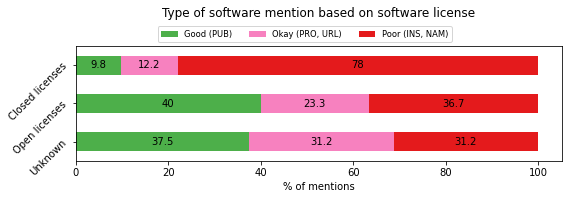

In [10]:
# Colourblind/-friendly colours adapted from https://gist.github.com/thriveth/8560036
my_colors = ['#4daf4a', '#f781bf', '#e41a1c']

# Create the plot
#fig, ax = plt.subplots(nrows = 1)
ax = plot_df.plot(kind='barh', 
                   stacked=True,
                   figsize=(8, 3), 
                   color=my_colors)
ax.legend(ncol=3, 
          bbox_to_anchor=(0.16, 1),
          loc='lower left', 
          fontsize='small')
ax.set_xlabel('% of mentions')

# Add a title and rotate the x-axis labels to be horizontal
plt.title('Type of software mention based on software license', y=1.2)
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=45)

# Add value labels to bar sections (requires matplotlib >= 3.4.0)
for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
# Format, save, and show the plot
plt.tight_layout()
plt.savefig('mention-type-vs-license.pgf')
plt.show()